#### Import Libraries

In [1]:
import requests
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
import seaborn as sns
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
%matplotlib inline

#### Get Crypto Data 
- Source 1: CoinGecko Api
    - 180 days of bitcoin OHLC data
    - get_historical_data: pulls price data and stores in data frame

In [3]:
# Function to pull data from coin gecko
def get_historical_data(coin_id, vs_currency, days):
    url = f'https://api.coingecko.com/api/v3/coins/{coin_id}/market_chart'
    params = {'vs_currency': vs_currency, 'days': days}
    
    print(f"Requesting data for: {coin_id}, Currency: {vs_currency}, Days: {days}")
    
    response = requests.get(url, params=params)
    if response.status_code == 200:
        data = response.json()
        df = pd.DataFrame(data['prices'], columns=['timestamp', 'price'])
        df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
        return df
    else:
        print(f"Error fetching data: {response.status_code}")
        print(response.json())  # Print the error response for more detail
        return None

In [4]:
# Fetch : Fetch 180 days of Bitcoin data
data = get_historical_data('bitcoin', 'usd', 180)

if data is not None:
    print(data.head())

Requesting data for: bitcoin, Currency: usd, Days: 180
   timestamp         price
0 2024-07-17  65162.236252
1 2024-07-18  64136.313844
2 2024-07-19  63959.569008
3 2024-07-20  66689.548807
4 2024-07-21  67206.064706


In [5]:
# Verify Data
print(len(data)) 
print(data['timestamp'].min(), data['timestamp'].max())  # Check the date range

181
2024-07-17 00:00:00 2025-01-12 00:38:05


### Define Indicators
- RSI, 50 MA, MACD

In [7]:
# Define the RSI
def rsi(data, window=14):
    delta = data['price'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

In [8]:
# Apply RSI 
data['rsi'] = rsi(data)

In [9]:
# Define moving_average function for testing different MA's
def moving_average(data, window=50):
    return data['price'].rolling(window=window).mean()

In [10]:
# Apply a 50-period MA 
data['50_ma'] = moving_average(data)

In [11]:
def macd(data, fast_period=12, slow_period=26, signal_period=9):
    # Calculate the EMAs
    fast_ema = data['price'].ewm(span=fast_period, min_periods=fast_period).mean()
    slow_ema = data['price'].ewm(span=slow_period, min_periods=slow_period).mean()
    
    # Calculate MACD
    macd = fast_ema - slow_ema
    signal = macd.ewm(span=signal_period, min_periods=signal_period).mean()

    return macd, signal

In [14]:
# Apply MACD and MACD Signal to your data
data['macd'], data['macd_signal'] = macd(data)

### Check Defined Indicators for creation of new NaN values 

   timestamp         price  50_ma
0 2024-07-17  65162.236252    NaN
1 2024-07-18  64136.313844    NaN
2 2024-07-19  63959.569008    NaN
3 2024-07-20  66689.548807    NaN
4 2024-07-21  67206.064706    NaN
5 2024-07-22  68088.139963    NaN
6 2024-07-23  67607.713399    NaN
7 2024-07-24  65942.417465    NaN
8 2024-07-25  65403.535130    NaN
9 2024-07-26  65749.963620    NaN


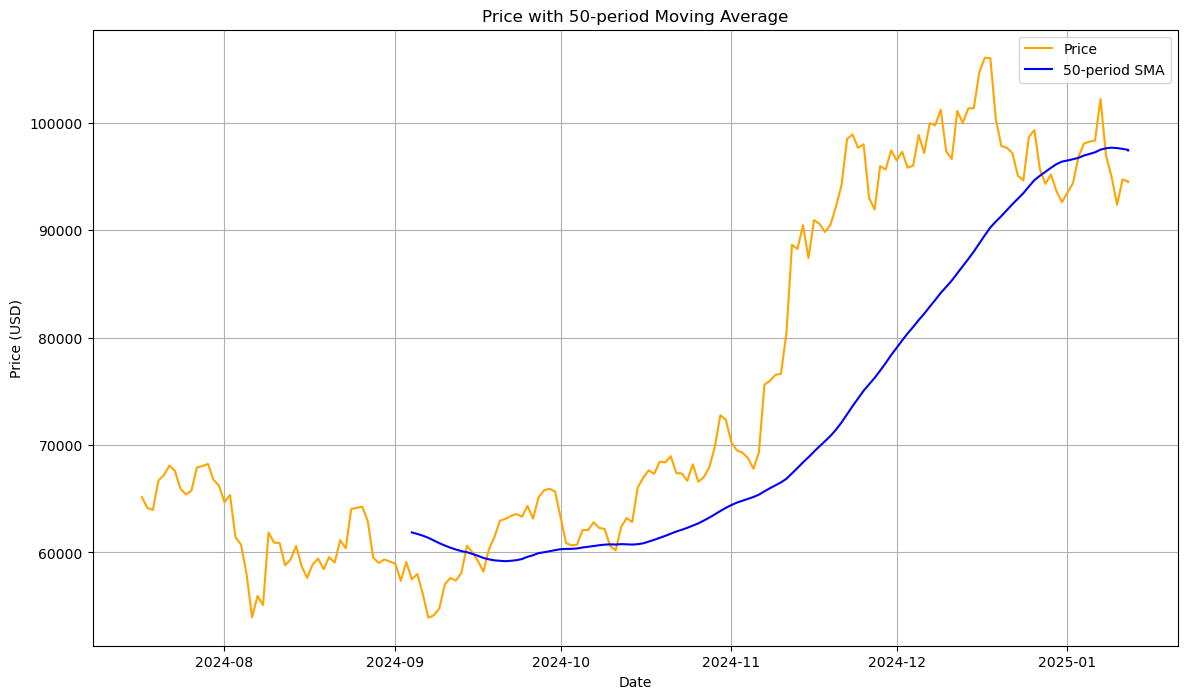

In [24]:
# Check the first few rows to make sure the 50-period moving average is calculated correctly
print(data[['timestamp', 'price', '50_ma']].head(10))  # Check the first 60 rows to see the MA in action

# Plot the price and 50-period moving average
plt.figure(figsize=(14, 8))
plt.plot(data['timestamp'], data['price'], label='Price', color='orange')
plt.plot(data['timestamp'], data['50_ma'], label='50-period SMA', color='blue')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.title('Price with 50-period Moving Average')
plt.legend()
plt.grid(True)
plt.show()

#### Notice above that the 50 MA isn't aligned to the entirety of the price data
- We need to reclean the data to handle the NaNs that are generated by adding indicators to the dataframe

In [27]:
# Drop rows where '50_ma' column has NaN values
data_clean = data.dropna(subset=['50_ma'])

print(data_clean.head(10)) 
print(f"Number of rows in cleaned data: {len(data_clean)}")  # How many rows are left after cleaning


    timestamp         price        rsi         50_ma         macd  macd_signal
49 2024-09-04  57504.538586  45.594699  61868.621492  -700.245419  -413.018519
50 2024-09-05  57987.846014  40.168424  61725.133687  -755.629815  -481.748502
51 2024-09-06  56132.404732  37.596454  61565.055505  -935.877048  -572.794347
52 2024-09-07  53923.356111  17.750141  61364.331247 -1239.820796  -706.458180
53 2024-09-08  54150.938359  18.374595  61113.559038 -1445.846947  -854.565118
54 2024-09-09  54792.407558  21.034159  60865.285895 -1540.235844  -991.869237
55 2024-09-10  57049.118751  32.991436  60644.505471 -1418.809614 -1077.341961
56 2024-09-11  57624.161783  43.415128  60444.834439 -1262.150387 -1114.332953
57 2024-09-12  57381.764445  44.238534  60273.621378 -1144.152366 -1120.300618
58 2024-09-13  58106.951230  45.727408  60127.689700  -981.381172 -1092.502634
Number of rows in cleaned data: 132


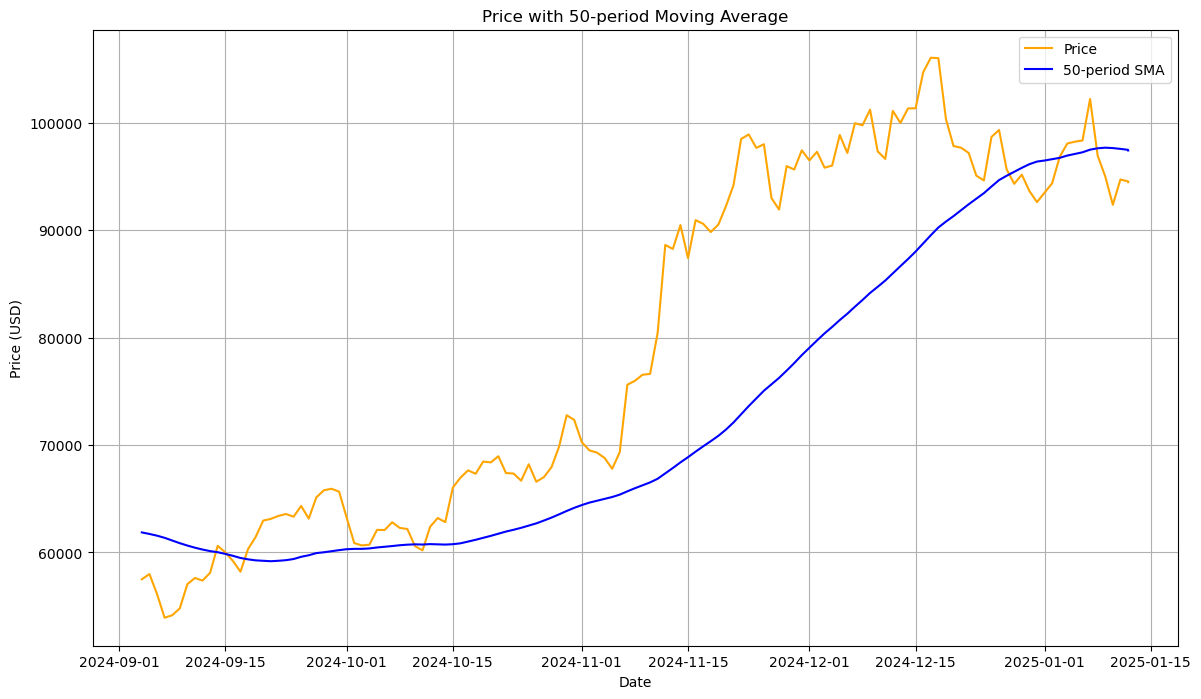

In [29]:
# Plot the price and 50-period moving average, skipping NaNs
plt.figure(figsize=(14, 8))
plt.plot(data_clean['timestamp'], data_clean['price'], label='Price', color='orange')
plt.plot(data_clean['timestamp'], data_clean['50_ma'], label='50-period SMA', color='blue')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.title('Price with 50-period Moving Average')
plt.legend()
plt.grid(True)
plt.show()

##### 50 MA is aligned to price data 

#### Test RSI
- Ensure proper calculation of RSI
- Observe new NaN values
- Reclean dataset

    timestamp         price        rsi
0  2024-07-17  65162.236252        NaN
1  2024-07-18  64136.313844        NaN
2  2024-07-19  63959.569008        NaN
3  2024-07-20  66689.548807        NaN
4  2024-07-21  67206.064706        NaN
5  2024-07-22  68088.139963        NaN
6  2024-07-23  67607.713399        NaN
7  2024-07-24  65942.417465        NaN
8  2024-07-25  65403.535130        NaN
9  2024-07-26  65749.963620        NaN
10 2024-07-27  67920.296486        NaN
11 2024-07-28  68055.408390        NaN
12 2024-07-29  68242.247444        NaN
13 2024-07-30  66770.320918  56.522886
14 2024-07-31  66219.051025  54.103258
15 2024-08-01  64679.778647  52.029201
16 2024-08-02  65357.529608  55.031492
17 2024-08-03  61407.295474  32.523403
18 2024-08-04  60738.744925  28.815672
19 2024-08-05  58006.206587  20.546258


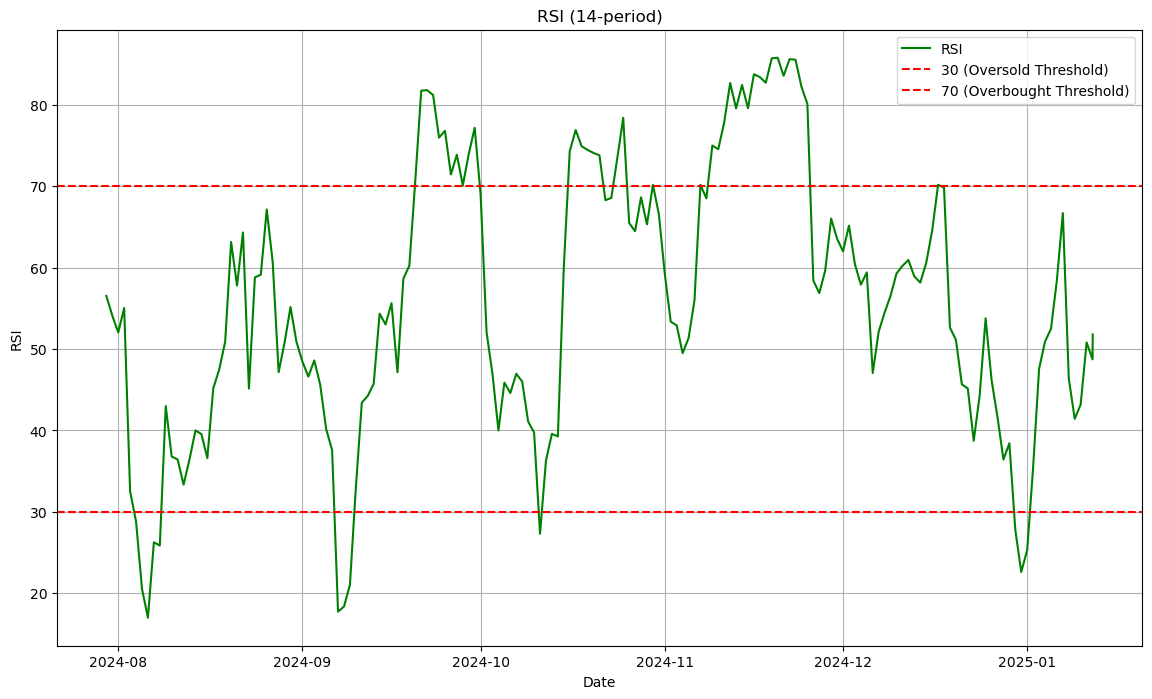

In [33]:
# Check the first few rows to ensure RSI is being calculated correctly
print(data[['timestamp', 'price', 'rsi']].head(20))  # Display the first 60 rows to check the RSI values

# Plot the RSI to verify it behaves as expected
plt.figure(figsize=(14, 8))
plt.plot(data['timestamp'], data['rsi'], label='RSI', color='green')
plt.axhline(y=30, color='red', linestyle='--', label='30 (Oversold Threshold)')
plt.axhline(y=70, color='red', linestyle='--', label='70 (Overbought Threshold)')
plt.xlabel('Date')
plt.ylabel('RSI')
plt.title('RSI (14-period)')
plt.legend()
plt.grid(True)
plt.show()

In [35]:
# drop the resulting NaN
# Drop rows where the 'rsi' column has NaN values
data_clean.dropna(subset=['rsi'])

# Check the cleaned data
print(data_clean.head(5))  # Display the first 60 rows after cleaning
print(f"Number of rows in cleaned data: {len(data_clean)}")  # Check how many rows are left

    timestamp         price        rsi         50_ma         macd  macd_signal
49 2024-09-04  57504.538586  45.594699  61868.621492  -700.245419  -413.018519
50 2024-09-05  57987.846014  40.168424  61725.133687  -755.629815  -481.748502
51 2024-09-06  56132.404732  37.596454  61565.055505  -935.877048  -572.794347
52 2024-09-07  53923.356111  17.750141  61364.331247 -1239.820796  -706.458180
53 2024-09-08  54150.938359  18.374595  61113.559038 -1445.846947  -854.565118
Number of rows in cleaned data: 132


#### Test MACD

    timestamp         price         macd  macd_signal
0  2024-07-17  65162.236252          NaN          NaN
1  2024-07-18  64136.313844          NaN          NaN
2  2024-07-19  63959.569008          NaN          NaN
3  2024-07-20  66689.548807          NaN          NaN
4  2024-07-21  67206.064706          NaN          NaN
5  2024-07-22  68088.139963          NaN          NaN
6  2024-07-23  67607.713399          NaN          NaN
7  2024-07-24  65942.417465          NaN          NaN
8  2024-07-25  65403.535130          NaN          NaN
9  2024-07-26  65749.963620          NaN          NaN
10 2024-07-27  67920.296486          NaN          NaN
11 2024-07-28  68055.408390          NaN          NaN
12 2024-07-29  68242.247444          NaN          NaN
13 2024-07-30  66770.320918          NaN          NaN
14 2024-07-31  66219.051025          NaN          NaN
15 2024-08-01  64679.778647          NaN          NaN
16 2024-08-02  65357.529608          NaN          NaN
17 2024-08-03  61407.295474 

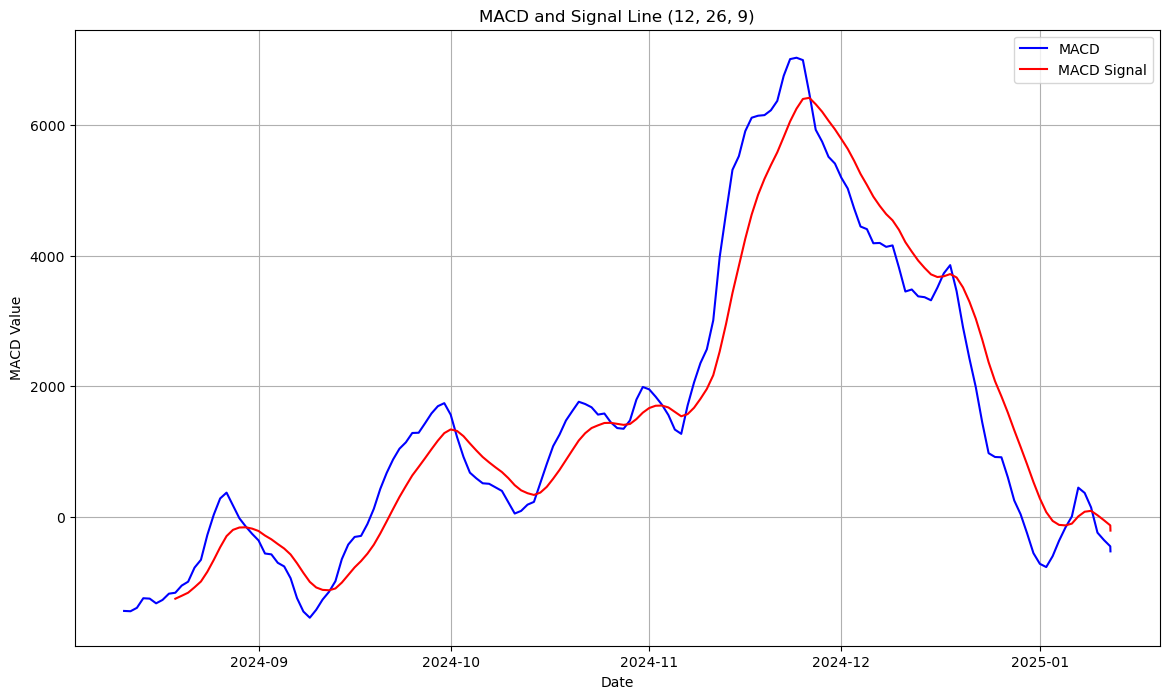

In [38]:
# Check the first few rows for MACD and Signal Line
print(data[['timestamp', 'price', 'macd', 'macd_signal']].head(40))  # Display the first 60 rows to check MACD values

# Plot the MACD and Signal line to visualize their interaction
plt.figure(figsize=(14, 8))
plt.plot(data['timestamp'], data['macd'], label='MACD', color='blue')
plt.plot(data['timestamp'], data['macd_signal'], label='MACD Signal', color='red')
plt.xlabel('Date')
plt.ylabel('MACD Value')
plt.title('MACD and Signal Line (12, 26, 9)')
plt.legend()
plt.grid(True)
plt.show()

In [40]:
# Drop NaN values in 'macd' and 'macd_signal' columns
data_clean.dropna(subset=['macd', 'macd_signal'])

# Check the cleaned data
print(data_clean.head(10))  
print(f"Number of rows in cleaned data: {len(data_clean)}")  


    timestamp         price        rsi         50_ma         macd  macd_signal
49 2024-09-04  57504.538586  45.594699  61868.621492  -700.245419  -413.018519
50 2024-09-05  57987.846014  40.168424  61725.133687  -755.629815  -481.748502
51 2024-09-06  56132.404732  37.596454  61565.055505  -935.877048  -572.794347
52 2024-09-07  53923.356111  17.750141  61364.331247 -1239.820796  -706.458180
53 2024-09-08  54150.938359  18.374595  61113.559038 -1445.846947  -854.565118
54 2024-09-09  54792.407558  21.034159  60865.285895 -1540.235844  -991.869237
55 2024-09-10  57049.118751  32.991436  60644.505471 -1418.809614 -1077.341961
56 2024-09-11  57624.161783  43.415128  60444.834439 -1262.150387 -1114.332953
57 2024-09-12  57381.764445  44.238534  60273.621378 -1144.152366 -1120.300618
58 2024-09-13  58106.951230  45.727408  60127.689700  -981.381172 -1092.502634
Number of rows in cleaned data: 132


#### Indicators are loading do a final comprehensive clean before creating signals 

In [43]:
# Drop rows where any of the key columns (RSI, MACD, 50 MA) have NaN values
data_clean = data.dropna(subset=['rsi', 'macd', 'macd_signal', '50_ma'])

# Check the cleaned data
print(data_clean.head(10))  # Display the first 60 rows after cleaning
print(f"Number of rows in cleaned data: {len(data_clean)}")  # Check how many rows are left

    timestamp         price        rsi         50_ma         macd  macd_signal
49 2024-09-04  57504.538586  45.594699  61868.621492  -700.245419  -413.018519
50 2024-09-05  57987.846014  40.168424  61725.133687  -755.629815  -481.748502
51 2024-09-06  56132.404732  37.596454  61565.055505  -935.877048  -572.794347
52 2024-09-07  53923.356111  17.750141  61364.331247 -1239.820796  -706.458180
53 2024-09-08  54150.938359  18.374595  61113.559038 -1445.846947  -854.565118
54 2024-09-09  54792.407558  21.034159  60865.285895 -1540.235844  -991.869237
55 2024-09-10  57049.118751  32.991436  60644.505471 -1418.809614 -1077.341961
56 2024-09-11  57624.161783  43.415128  60444.834439 -1262.150387 -1114.332953
57 2024-09-12  57381.764445  44.238534  60273.621378 -1144.152366 -1120.300618
58 2024-09-13  58106.951230  45.727408  60127.689700  -981.381172 -1092.502634
Number of rows in cleaned data: 132


#### Signal Logic

In [46]:
def generate_long_signals(data_clean):
    # Ensure a copy of the DataFrame is made to avoid SettingWithCopyWarning
    data_clean = data_clean.copy()

    # Entry Signal: RSI > 30, Price > 50 MA, MACD > MACD Signal
    data_clean['entry_signal'] = (
        (data_clean['rsi'] > 30) &
        (data_clean['price'] > data_clean['50_ma']) &
        (data_clean['macd'] > data_clean['macd_signal'])
    )

    # Exit Signal: MACD < MACD Signal, RSI < 70
    data_clean['exit_signal'] = (
        (data_clean['macd'] < data_clean['macd_signal']) &
        (data_clean['rsi'] < 70)
    )

    return data_clean

In [48]:
# Apply the function
data_clean = generate_long_signals(data_clean)

# Verify the columns
print(data_clean.columns)
print(data_clean[['entry_signal', 'exit_signal']].head())

Index(['timestamp', 'price', 'rsi', '50_ma', 'macd', 'macd_signal',
       'entry_signal', 'exit_signal'],
      dtype='object')
    entry_signal  exit_signal
49         False         True
50         False         True
51         False         True
52         False         True
53         False         True


#### Plot cleaned and generated signals

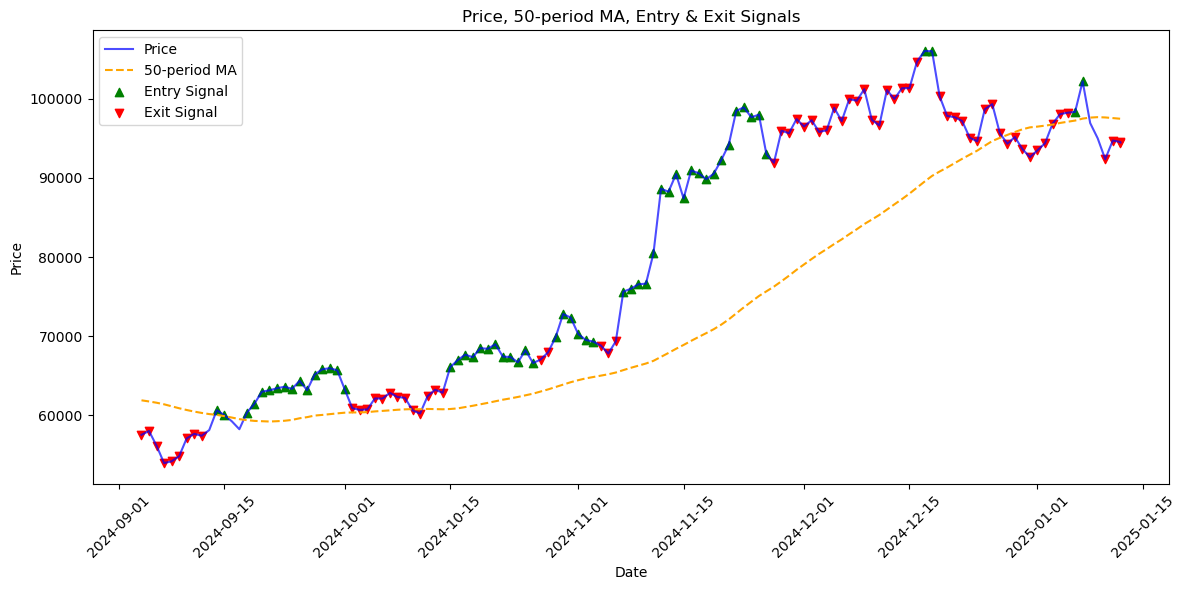

In [51]:
# Plot the price data and 50-period moving average
plt.figure(figsize=(12, 6))
plt.plot(data_clean['timestamp'], data_clean['price'], label='Price', color='blue', alpha=0.7)
plt.plot(data_clean['timestamp'], data_clean['50_ma'], label='50-period MA', color='orange', linestyle='--')

# Highlight the entry and exit signals
plt.scatter(data_clean[data_clean['entry_signal'] == True]['timestamp'], 
            data_clean[data_clean['entry_signal'] == True]['price'], 
            marker='^', color='green', label='Entry Signal', alpha=1)

plt.scatter(data_clean[data_clean['exit_signal'] == True]['timestamp'], 
            data_clean[data_clean['exit_signal'] == True]['price'], 
            marker='v', color='red', label='Exit Signal', alpha=1)

# Add labels and title
plt.title('Price, 50-period MA, Entry & Exit Signals')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(loc='upper left')

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()


#### This chart shows the current stage of signal generation based on the RSI, 50MA, and MACD
- While signals provide some clear entries, others lead to buys at local tops or critically missed upward movements
- The strategy is still a work in progress. This is not a test of a final product, but rather has become an exploration in generating signals, backtesting, and integrating machine learning into my trading strategies
- The purpose of this project is to demonstrate the mothodology and technical workflow required for projects of this scope.
- While the signals arent fully optimized yet, the frame TONS of overhead room to improve and refine in the future.
- New potential uses and applications are bound to present when I can achieve a more refined process

## Model Evaluation 1 : LogisticRegression
- Create target column for data
- train_test_split

In [197]:
# Add a target column to classify winning and losing trades
data_clean = data_clean.copy()  # Ensure we work with a copy to avoid SettingWithCopyWarning
data_clean['target'] = (data_clean['price'].shift(-1) > data_clean['price']).astype(int)

In [199]:
# train_test_split
X = data_clean[['rsi', '50_ma', 'macd']]  # Features
y = data_clean['target']  # Target Variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [201]:
# Initialize the model
model = LogisticRegression()

# Train the model
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)
# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Accuracy: 0.4074074074074074
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        16
           1       0.41      1.00      0.58        11

    accuracy                           0.41        27
   macro avg       0.20      0.50      0.29        27
weighted avg       0.17      0.41      0.24        27

Confusion Matrix:
[[ 0 16]
 [ 0 11]]


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Model Evaluation 2:  RandomForestClassifier

In [204]:
# Apply the function
data_clean = generate_long_signals(data_clean)

# Verify the columns
print(data_clean.columns)
print(data_clean[['entry_signal', 'exit_signal']].head())

Index(['timestamp', 'price', 'rsi', '50_ma', 'macd', 'macd_signal',
       'entry_signal', 'exit_signal', 'target'],
      dtype='object')
    entry_signal  exit_signal
49         False         True
50         False         True
51         False         True
52         False         True
53         False         True


In [211]:
# Split the data into features (X) and target (y)
X = data_clean[['rsi', '50_ma', 'macd','bullish_engulfing','near_resistance','pre_breakout_signal','price_breakout']]  # Feature columns
y = data_clean['target']  # Target column

- macd_above_signal
- near_resistance
- pre_breakout_signal
- price_breakout
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the classifier (Random Forest)
rf_model = RandomForestClassifier(random_state=42)

# Train the model
rf_model.fit(X_train_res, y_train_res)

# Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


KeyError: "['bullish_engulfing', 'near_resistance', 'pre_breakout_signal', 'price_breakout'] not in index"

##### Observing similar results between LogisticRegression and RandomForestClassifier
- To me... this indicates that the signals are missing something, not entering on lows or prebreakout
## Generate New Signals: Include Price Action signals to enhance the entry conditions.
- Pre-breakout signal: Price near resistance, RSI Increasing but not oversold.
- Bullish Engulfing Candle
- price near resistance, yet to breakout
- Pull-back entry signals: RSI oversold, price near support

In [209]:
# long signal with price action
def generate_long_signals_with_price_action(data):
    # Entry Signal: Look for pre-breakout (Price near previous resistance, RSI below 70 but increasing)
    data.loc[:, 'price_breakout'] = data['price'] > data['50_ma']  # Price above SMA (for trend confirmation)
    data.loc[:, 'rsi_above_30'] = data['rsi'] > 30  # RSI increasing
    data.loc[:, 'macd_above_signal'] = data['macd'] > data['macd_signal']  # MACD crossover
    data.loc[:, 'near_resistance'] = data['price'] > (data['50_ma'] * 0.99)  # Price is near resistance (e.g., 1% away)

    # Look for a Bullish Engulfing pattern
    data.loc[:, 'bullish_engulfing'] = (data['price'] > data['price'].shift(1)) & (data['price'].shift(1) < data['price'].shift(2))

    # Early breakout condition: Price near resistance but hasn't broken out yet
    data.loc[:, 'pre_breakout_signal'] = data['near_resistance'] & data['rsi_above_30'] & data['macd_above_signal'] & data['bullish_engulfing']

    # Pullback entry (RSI oversold, price near support)
    data.loc[:, 'price_pullback'] = data['price'] < data['50_ma']  # If price is below 50-period SMA
    data.loc[:, 'rsi_oversold'] = data['rsi'] < 30  # RSI < 30 for a potential pullback buy

    # Combine conditions for entry signal
    data.loc[:, 'long_entry_signal'] = (data['price_breakout'] | data['pre_breakout_signal'] | data['price_pullback']) & data['rsi_above_30'] & data['macd_above_signal']

    # Exit Signal: Price breaks below the 50-period SMA, RSI > 70, MACD < MACD Signal
    data.loc[:, 'price_below_sma'] = data['price'] < data['50_ma']
    data.loc[:, 'rsi_above_70'] = data['rsi'] > 70
    data.loc[:, 'macd_below_signal'] = data['macd'] < data['macd_signal']
    
    # Combine conditions for exit signal
    data.loc[:, 'long_exit_signal'] = data['price_below_sma'] & data['rsi_above_70'] & data['macd_below_signal']
    
    return data

In [ ]:
# Generate new signals
data_with_signals = generate_long_signals_with_price_action(data_clean)

### Model Evaluation 3: RadomForestClassifier on adjusted signals

In [68]:
#traintestsplit
# Features (X) and target (y)
X = data_clean[['rsi', '50_ma', 'macd', 'price_breakout', 'rsi_above_30', 'macd_above_signal', 'near_resistance', 'bullish_engulfing', 'pre_breakout_signal', 'price_pullback', 'rsi_oversold']]
y = data_clean['target']  # The target variable (price goes up or down)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


KeyError: "['price_breakout', 'rsi_above_30', 'macd_above_signal', 'near_resistance', 'bullish_engulfing', 'pre_breakout_signal', 'price_pullback', 'rsi_oversold'] not in index"

In [70]:
# Initialize the Random Forest model
model = RandomForestClassifier(random_state=42)

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Print the evaluation metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Accuracy: 0.4444444444444444
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.06      0.12        16
           1       0.42      1.00      0.59        11

    accuracy                           0.44        27
   macro avg       0.71      0.53      0.36        27
weighted avg       0.76      0.44      0.31        27

Confusion Matrix:
[[ 1 15]
 [ 0 11]]


##### Showing improvement on Accuracy : Visualize the Results

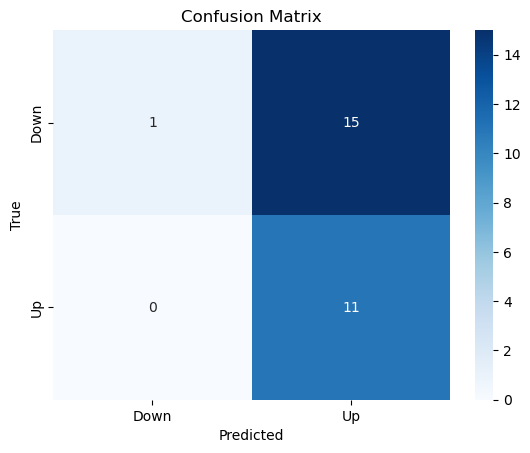

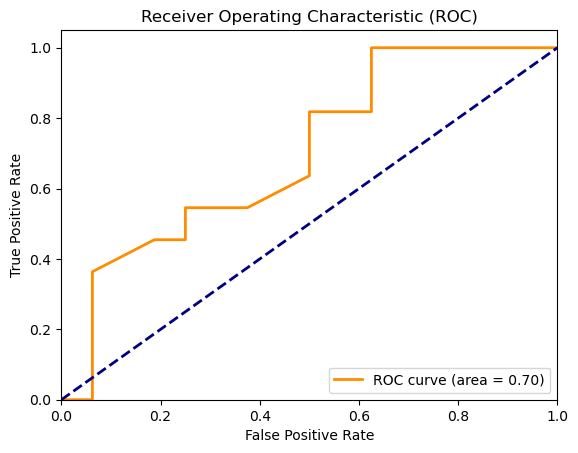

In [73]:
# visualize the confusion matrixs and ROC

# Confusion Matrix Visualization
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Down", "Up"], yticklabels=["Down", "Up"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# ROC Curve (for binary classification)
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC)")
plt.legend(loc="lower right")
plt.show()


##### Positive ROC curve area indicates that we are on the good side of 50%
### model is missing a good amount of upmoves, a concerning amount
- try implementing grid search

In [76]:
# Split the data into features (X) and target (y)
#X = data_clean[['rsi', '50_ma', 'macd']]  # Feature columns
X = data_clean[['rsi', '50_ma', 'macd', 'price_breakout', 'rsi_above_30', 'macd_above_signal', 'near_resistance', 'bullish_engulfing', 'pre_breakout_signal', 'price_pullback', 'rsi_oversold']]
y = data_clean['target']  # Target column

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE to balance the class distribution (optional step based on previous results)
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Initialize the Random Forest model with class weight adjustment
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)

# Hyperparameter tuning using GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Grid search for hyperparameter tuning
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train_res, y_train_res)

# Best model from grid search
best_rf_model = grid_search.best_estimator_

# Make predictions on the test set
y_pred = best_rf_model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

# If needed, you can also evaluate using a confusion matrix
from sklearn.metrics import confusion_matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


KeyError: "['price_breakout', 'rsi_above_30', 'macd_above_signal', 'near_resistance', 'bullish_engulfing', 'pre_breakout_signal', 'price_pullback', 'rsi_oversold'] not in index"

##### Grid shows decrease in Accuracy
- I'm noticing with all these Evaluations is that we just dont have a large enough sample

### Model Evaluation 4: XGBoost for crypto
- omitting this section as I have to pay for XGBoost or figure out some alternative means of installation

### Model Evaluation 5: Trying a LogisticRegression again now that we have adjusted our data and singals

In [81]:
#traintestsplit
# Features (X) and target (y)
X = data_clean[['rsi', '50_ma', 'macd', 'price_breakout', 'rsi_above_30', 'macd_above_signal', 'near_resistance', 'bullish_engulfing', 'pre_breakout_signal', 'price_pullback', 'rsi_oversold']]
y = data_clean['target']  # The target variable (price goes up or down)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE to balance the class distribution 
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

KeyError: "['price_breakout', 'rsi_above_30', 'macd_above_signal', 'near_resistance', 'bullish_engulfing', 'pre_breakout_signal', 'price_pullback', 'rsi_oversold'] not in index"

In [83]:
# Initialize Logistic Regression
logreg = LogisticRegression()

# Train the model
logreg.fit(X_train, y_train)

# Predict
y_pred_logreg = logreg.predict(X_test)

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred_logreg))
print("Classification Report:")
print(classification_report(y_test, y_pred_logreg))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Accuracy: 0.4074074074074074
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        16
           1       0.41      1.00      0.58        11

    accuracy                           0.41        27
   macro avg       0.20      0.50      0.29        27
weighted avg       0.17      0.41      0.24        27

Confusion Matrix:
[[ 1 15]
 [ 0 11]]


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [85]:

# Split data
X = data_clean[['rsi', '50_ma', 'macd']]  # Features
y = data_clean['target']  # Target

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize RandomForestClassifier
rf = RandomForestClassifier(random_state=42)

# Train model
rf.fit(X_train, y_train)

# Predictions
y_pred = rf.predict(X_test)

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 0.5185185185185185
Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.54      0.52        13
           1       0.54      0.50      0.52        14

    accuracy                           0.52        27
   macro avg       0.52      0.52      0.52        27
weighted avg       0.52      0.52      0.52        27



#### Attempt a standard scalling of features and crossvalidate the accuracy scores to get generalize feature accuracy

In [88]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train with cross-validation using Random Forest
rf = RandomForestClassifier(random_state=42)
cross_val_scores = cross_val_score(rf, X_scaled, y, cv=5, scoring='accuracy')

print("Cross-validation accuracy scores:", cross_val_scores)
print("Average cross-validation accuracy:", cross_val_scores.mean())


Cross-validation accuracy scores: [0.51851852 0.37037037 0.30769231 0.34615385 0.61538462]
Average cross-validation accuracy: 0.4316239316239316


### Feature Engineering
- we have hit an accuracy of 51%, which is okay for trading.
- if of the 100% of the trades we take, 51% are profitable, and 49% are losses
- if we define exit signals that cut the 49% of trades that lose, we can mitigate losses.
- cutting the losses and running the profits at a 49% win rate, we get a positive yearly return.

#### proposed solutions
- add rolling mean/median for RSI,MACD, and other indicators
    - this smooths price to capture longer-term trend
- add standard deviations for RSI,MACD, and other indicators
    - to capture price volatility and mean reversion plays
- Lag Price & other features
    - use % change in daily price to capture momentum swings
    - see if the machine can get anything from lagging other featuers for RSI, MACD, and SMA
- Combine Features
    - capture relationships between variables
- RSI Zones
    - categorize the RSI into zones for oversold, neutral, and overbought
    - this could give the model better insights
- Moving Average Crosses
    - Moving average crossovers signal price movement, just need to find the right periods
- Price Volatility
    - Measure volatitily over different time periods
- Trend Indicators
    - Average directional index (ADX) to guage trend strength
    - I don't have ADX so i'm gonna create one myself??
        - (long period SMA - short period SMA)

## Generate Some new features
- based on pinescripts and other searched up indicator functions

In [93]:
def calculate_rsi(prices, window=14):
    delta = prices.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

In [95]:
def calculate_sma(prices, window=50):
    return prices.rolling(window=window).mean()

In [97]:
def calculate_macd(prices, short_window=12, long_window=26, signal_window=9):
    short_ema = prices.ewm(span=short_window, adjust=False).mean()
    long_ema = prices.ewm(span=long_window, adjust=False).mean()
    macd = short_ema - long_ema
    signal = macd.ewm(span=signal_window, adjust=False).mean()
    return macd, signal


In [99]:
# new feature generation function
def generate_features(data):
    data['rsi'] = calculate_rsi(data['price'])
    data['50_ma'] = calculate_sma(data['price'])
    data['macd'], data['macd_signal'] = calculate_macd(data['price'])
    return data


In [101]:
# test set
data_features = generate_features(data)

#### traintestsplit the new model

In [104]:

# Define your features and target
X = data_clean[['rsi', '50_ma', 'macd', 'price_breakout', 'rsi_above_30', 'macd_above_signal', 'price_pullback', 'rsi_oversold', 'pre_breakout_signal']]  # Add all features here
y = data_clean['target']  # Target variable (price will go up or down)

# Split into training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE to balance the class distribution in the training set
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Initialize the RandomForestClassifier with class_weight='balanced'
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)

# Train the model
rf_model.fit(X_train_res, y_train_res)

# Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


KeyError: "['price_breakout', 'rsi_above_30', 'macd_above_signal', 'price_pullback', 'rsi_oversold', 'pre_breakout_signal'] not in index"

## Closing Notes
#### Move to a new notebook now this is getting cluttered
- I want better recall for profitable trades (class 1) without too much overfitting. Improving class recall while maintaining accuracy, even if it means slightly sacrificing precision, will give result in the most valuable information for a trading system.
- We have a lack of data, these confustion matrixes are too small. Seek to revamp data collection.
- Clean up the process and make targeted changes:
    - Work on improving class weights.
    - Keep fine-tuning feature engineering and try other models once we’ve adjusted for better performance.
- Create modular testing template to use as a base for new experiments/test
    - For each test set
      - load data
      - implement any desired feature adjustments
      - fine-tune classweights / SMOTE class balance settings
      - Run models on fresh data

# Section 2: New Data
- revamped data collection to use a handdownloaded bitcoin OHLC CSV from cryptodatadownload.com
- new data means new opportunities!
- we have access to a lot more data this way, 2024-2017 daily and hourly OHLC CSV's

In [137]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

In [139]:
csv_files = ["Binance_BTCUSDT_1h.csv", "Binance_BTCUSDT_d.csv"]
dataframes = []

for file in csv_files:
    try:
        df = pd.read_csv(file, skiprows=1)
        dataframes.append(df)
    except FileNotFoundError:
        print(f"Error: File not found - {file}")
        dataframes.append(None)

# Check for missing data
if dataframes[1] is None:
    print("Daily data is missing. Proceeding with hourly data only.")
    btc_1h = dataframes[0]
    # Placeholder for when daily data is added
    btc_combined = btc_1h.copy()
else:
    btc_1h, btc_1 = dataframes
    print("Files loaded successfully.")

    # Multi-Timeframe Integration
    btc_1h["time"] = pd.to_datetime(btc_1h["Unix"], unit="ms")
    btc_1["time"] = pd.to_datetime(btc_1["Unix"], unit="ms")
    btc_1h.set_index("time", inplace=True)
    btc_1.set_index("time", inplace=True)

    # Join dataframes
    btc_combined = btc_1h.join(btc_1, how="inner", lsuffix="_1h", rsuffix="_d")

Files loaded successfully.


##### Files load. Multitimeframe data integration is operational.
- Next step: Verify DataFrame has good OHLC data

In [142]:
# Verify basic structure
for name, df in zip(["Hourly", "Daily"], dataframes):
    print(f"--- {name} Data ---")
    print("Shape:", df.shape)
    print("Columns:", df.columns)
    print("Data Types:\n", df.dtypes)
    print(df.head(), "\n")
    print(df.describe(), "\n")

--- Hourly Data ---
Shape: (64012, 10)
Columns: Index(['Unix', 'Date', 'Symbol', 'Open', 'High', 'Low', 'Close', 'Volume BTC',
       'Volume USDT', 'tradecount'],
      dtype='object')
Data Types:
 Unix             int64
Date            object
Symbol          object
Open           float64
High           float64
Low            float64
Close          float64
Volume BTC     float64
Volume USDT    float64
tradecount       int64
dtype: object
                              Unix                 Date   Symbol      Open  \
time                                                                         
2024-12-10 23:00:00  1733871600000  2024-12-10 23:00:00  BTCUSDT  96849.45   
2024-12-10 22:00:00  1733868000000  2024-12-10 22:00:00  BTCUSDT  96858.00   
2024-12-10 21:00:00  1733864400000  2024-12-10 21:00:00  BTCUSDT  96434.75   
2024-12-10 20:00:00  1733860800000  2024-12-10 20:00:00  BTCUSDT  95856.50   
2024-12-10 19:00:00  1733857200000  2024-12-10 19:00:00  BTCUSDT  95132.04   

          

In [144]:
# Check for missing values
for name, df in zip(["Hourly", "Daily"], dataframes):
    print(f"--- Missing Values in {name} Data ---")
    print(df.isnull().sum(), "\n")

--- Missing Values in Hourly Data ---
Unix           0
Date           0
Symbol         0
Open           0
High           0
Low            0
Close          0
Volume BTC     0
Volume USDT    0
tradecount     0
dtype: int64 

--- Missing Values in Daily Data ---
Unix           0
Date           0
Symbol         0
Open           0
High           0
Low            0
Close          0
Volume BTC     0
Volume USDT    0
tradecount     0
dtype: int64 



In [146]:
# Display Multitimeframe Datasets
btc_1h = dataframes[0]
btc_d = dataframes[1]
print(btc_1h.head())
print(btc_d.head())

                              Unix                 Date   Symbol      Open  \
time                                                                         
2024-12-10 23:00:00  1733871600000  2024-12-10 23:00:00  BTCUSDT  96849.45   
2024-12-10 22:00:00  1733868000000  2024-12-10 22:00:00  BTCUSDT  96858.00   
2024-12-10 21:00:00  1733864400000  2024-12-10 21:00:00  BTCUSDT  96434.75   
2024-12-10 20:00:00  1733860800000  2024-12-10 20:00:00  BTCUSDT  95856.50   
2024-12-10 19:00:00  1733857200000  2024-12-10 19:00:00  BTCUSDT  95132.04   

                         High       Low     Close  Volume BTC   Volume USDT  \
time                                                                          
2024-12-10 23:00:00  97128.62  96402.70  96593.00  1199.51886  1.161477e+08   
2024-12-10 22:00:00  97099.49  96587.43  96849.44  1109.33596  1.074380e+08   
2024-12-10 21:00:00  97200.70  96382.35  96858.00  2026.89962  1.961670e+08   
2024-12-10 20:00:00  96700.00  95616.00  96434.76  1949.38

## Multi-Timeframe integration
- convert time to datatime format
- verify time alignment
- clean it up a bit

In [149]:
# Convert time columns to datetime format and set as index
for df in dataframes:
    df["time"] = pd.to_datetime(df["Unix"], unit="ms")
    df.set_index("time", inplace=True)
    df.drop(columns=["Unix"], inplace=True)

In [151]:
# Align and merge hourly and daily data
btc_combined = btc_1h.join(btc_d, how="inner", lsuffix="_1h", rsuffix="_d")

In [153]:
# verify the time ranges
print("--- Hourly Time Range ---")
print(btc_1h.index.min(), "to", btc_1h.index.max())

print("--- Daily Time Range ---")
print(btc_d.index.min(), "to", btc_d.index.max())

print("--- Combined Time Range ---")
print(btc_combined.index.min(), "to", btc_combined.index.max())

# Verify timestamp alignment in combined data
print("--- Sample Combined Timestamps ---")
print(btc_combined.index[:5])

# Plot Close Prices to verify alignment
plt.figure(figsize=(12, 6))
btc_combined["Close_1h"].plot(label="Hourly Close", alpha=0.7)


--- Hourly Time Range ---
2017-08-17 04:00:00 to 2024-12-10 23:00:00
--- Daily Time Range ---
2017-08-17 00:00:00 to 2024-12-10 00:00:00
--- Combined Time Range ---
2017-08-18 00:00:00 to 2024-12-07 00:00:00
--- Sample Combined Timestamps ---
DatetimeIndex(['2024-12-07', '2024-12-06', '2024-12-05', '2024-12-04',
               '2024-12-03'],
              dtype='datetime64[ns]', name='time', freq=None)


<Axes: xlabel='time'>

           Open_1h      High_1h       Low_1h     Close_1h  Volume BTC_1h  \
count  2666.000000  2666.000000  2666.000000  2666.000000    2666.000000   
mean      9.818279     9.823993     9.812312     9.818460       7.401711   
std       0.894427     0.894073     0.894870     0.894424       1.170326   
min       8.067466     8.078651     8.056113     8.075583       1.207145   
25%       9.047050     9.050365     9.037086     9.047077       6.852375   
50%       9.902327     9.909877     9.898703     9.904518       7.397468   
75%      10.633304    10.639521    10.629014    10.635773       8.066526   
max      11.510341    11.516989    11.508219    11.515652      11.108869   

       Volume USDT_1h  tradecount_1h       Open_d       High_d        Low_d  \
count     2666.000000    2666.000000  2666.000000  2666.000000  2666.000000   
mean        17.217838      10.320683     9.818279     9.843511     9.790120   
std          1.615459       1.462705     0.894427     0.893122     0.896574   

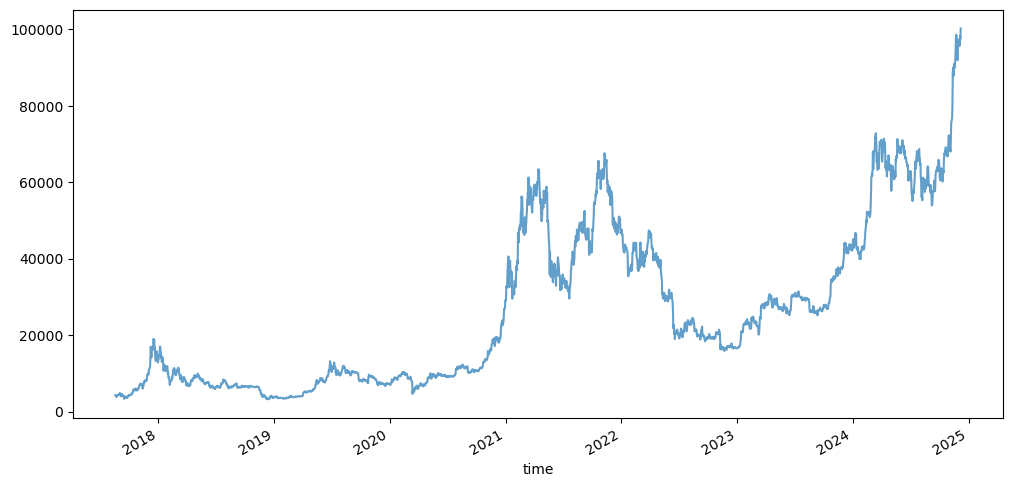

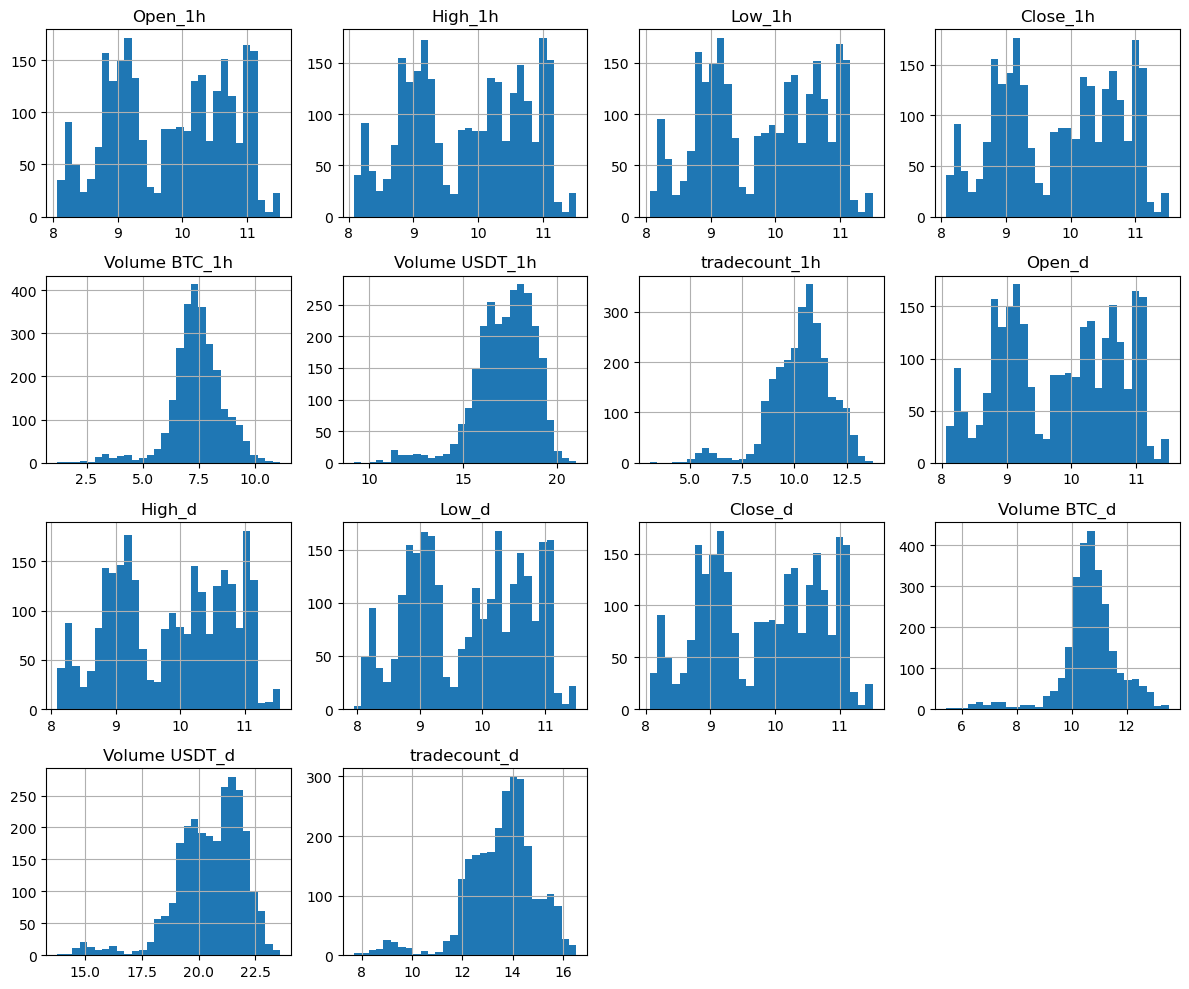

In [155]:
# Normalize numeric columns using log scaling
numeric_cols = btc_combined.select_dtypes(include=["float64", "int64"]).columns
btc_combined[numeric_cols] = btc_combined[numeric_cols].apply(
    lambda x: np.log1p(x.clip(lower=1e-9))
)
# normalize 
scaler = StandardScaler()

# Check descriptive statistics after normalization
print(btc_combined[numeric_cols].describe())

# Plot histograms to ensure normalization effect
btc_combined[numeric_cols].hist(figsize=(12, 10), bins=30)
plt.tight_layout()
plt.show()


##### Looks good to me 
### Feature Engineering || Signal Generation
- implement new indicators
- generate signals from indicators

In [157]:
# Add indicators for combined data
btc_combined["SMA_20"] = btc_combined["Close_1h"].rolling(window=20).mean()
btc_combined["SMA_50"] = btc_combined["Close_1h"].rolling(window=50).mean()
btc_combined["RSI"] = 100 - (100 / (1 + (btc_combined["Close_1h"].diff(1).clip(lower=0).rolling(14).mean() /
                                        -btc_combined["Close_1h"].diff(1).clip(upper=0).rolling(14).mean())))
btc_combined["MACD"] = (btc_combined["Close_1h"].ewm(span=12, adjust=False).mean() -
                         btc_combined["Close_1h"].ewm(span=26, adjust=False).mean())
btc_combined["Signal_Line"] = btc_combined["MACD"].ewm(span=9, adjust=False).mean()


In [160]:
# SMA Crossover Signals: Detect long-term trends
btc_combined["Signal_SMA"] = np.where(
    (btc_combined["SMA_20"].shift(1) <= btc_combined["SMA_50"].shift(1)) & 
    (btc_combined["SMA_20"] > btc_combined["SMA_50"]),
    1,       # Buy Signal
    np.where(
        (btc_combined["SMA_20"].shift(1) >= btc_combined["SMA_50"].shift(1)) & 
        (btc_combined["SMA_20"] < btc_combined["SMA_50"]),
        -1,  # Sell Signal
        0    # Hold
    )
)

# RSI Overbought/Oversold Signals: Identify potential reversals
btc_combined["Signal_RSI"] = np.where(
    btc_combined["RSI"] < 30, 1,               # Oversold - Buy Signal
    np.where(btc_combined["RSI"] > 70, -1, 0)  # Overbought - Sell Signal
)

# MACD Trend Strength Signals: Follow momentum shifts
btc_combined["Signal_MACD"] = np.where(
    btc_combined["MACD"] > btc_combined["Signal_Line"], 1, -1
)

# Combine Signals into One Decision
btc_combined["Signal_Combined"] = (
    btc_combined["Signal_SMA"] * 0.5 + 
    btc_combined["Signal_RSI"] * 0.3 + 
    btc_combined["Signal_MACD"] * 0.2
)
btc_combined["Signal_Combined"] = np.sign(btc_combined["Signal_Combined"])


#### New Signals means new NaN's

In [163]:
# Drop unnecessary columns (adjust as needed)
btc_combined.drop(columns=["Date_1h", "Symbol_1h", "Date_d", "Symbol_d"], inplace=True, errors="ignore")

# Drop rows with NaN values to ensure a clean dataset
btc_combined.dropna(inplace=True)

# Verify final dataset shape and cleanliness
print(btc_combined.isnull().sum())
print("Final Shape:", btc_combined.shape)


Open_1h            0
High_1h            0
Low_1h             0
Close_1h           0
Volume BTC_1h      0
Volume USDT_1h     0
tradecount_1h      0
Open_d             0
High_d             0
Low_d              0
Close_d            0
Volume BTC_d       0
Volume USDT_d      0
tradecount_d       0
SMA_20             0
SMA_50             0
RSI                0
MACD               0
Signal_Line        0
Signal_SMA         0
Signal_RSI         0
Signal_MACD        0
Signal_Combined    0
dtype: int64
Final Shape: (2617, 23)


##### 2617 is way better than 130 or whatever we were getting with CoinGecko's API!!!

### Model Evaluation : RandomForestClassifier
- define a target
- A Random Forest Classifier was selected for its robustness and ability to handle non-linear patterns
- The model was trained on a balanced dataset to improve classification performance
- split data
- train model

In [167]:
# Define target (y) and features (X)
target = "Signal_Combined"
features = btc_combined.drop(columns=["Signal_Combined"]).columns

X = btc_combined[features]
y = btc_combined[target]

# Verify shapes
print("Features Shape:", X.shape)
print("Target Shape:", y.shape)

Features Shape: (2617, 22)
Target Shape: (2617,)


In [169]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [171]:
# Train the model
model = RandomForestClassifier(random_state=42)
# Ensure only numeric columns are used
X_train_numeric = X_train.select_dtypes(include=["number"])
model.fit(X_train_numeric, y_train)
# Align test features with training features
X_test_aligned = X_test[X_train.columns]

In [172]:
# Predictions and metrics
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.9904580152671756
Classification Report:
               precision    recall  f1-score   support

        -1.0       0.99      0.99      0.99       214
         1.0       0.99      0.99      0.99       310

    accuracy                           0.99       524
   macro avg       0.99      0.99      0.99       524
weighted avg       0.99      0.99      0.99       524

Confusion Matrix:
 [[212   2]
 [  3 307]]


##### So as before, 99% is too good, we are off somewhere. Lets try ranking the signals and seeing what indicators are working the best

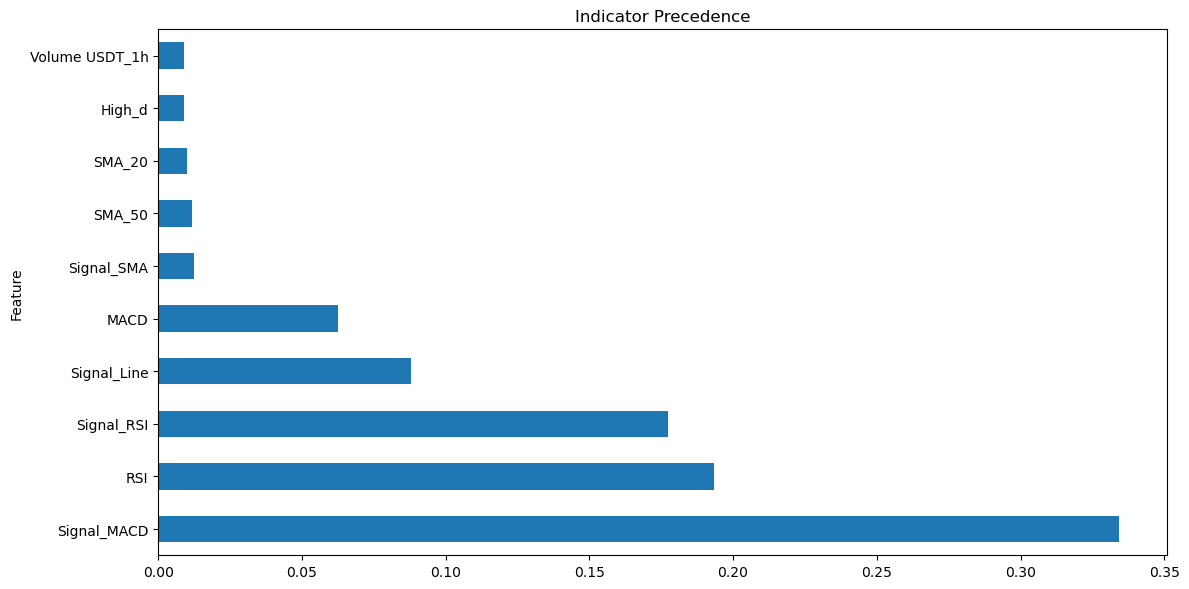

In [176]:
# Align feature importances with the columns used in training
feature_importances = pd.Series(model.feature_importances_, index=X_train.columns)

# Plot the top 10 most important features
plt.figure(figsize=(12, 6))
feature_importances.nlargest(10).plot(kind="barh", title="Indicator Precedence")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

In [178]:
# Visualize predictions and actuals
y_test_df = pd.DataFrame({"Actual": y_test, "Predicted": y_pred})
print("Sample Predictions vs Actuals:")
print(y_test_df.head())

Sample Predictions vs Actuals:
            Actual  Predicted
time                         
2017-09-27     1.0        1.0
2021-12-21    -1.0       -1.0
2018-09-24    -1.0       -1.0
2021-09-21     1.0        1.0
2019-06-23    -1.0       -1.0


##### model struggling a bit
##### plot Accuracy to see if that brings insights

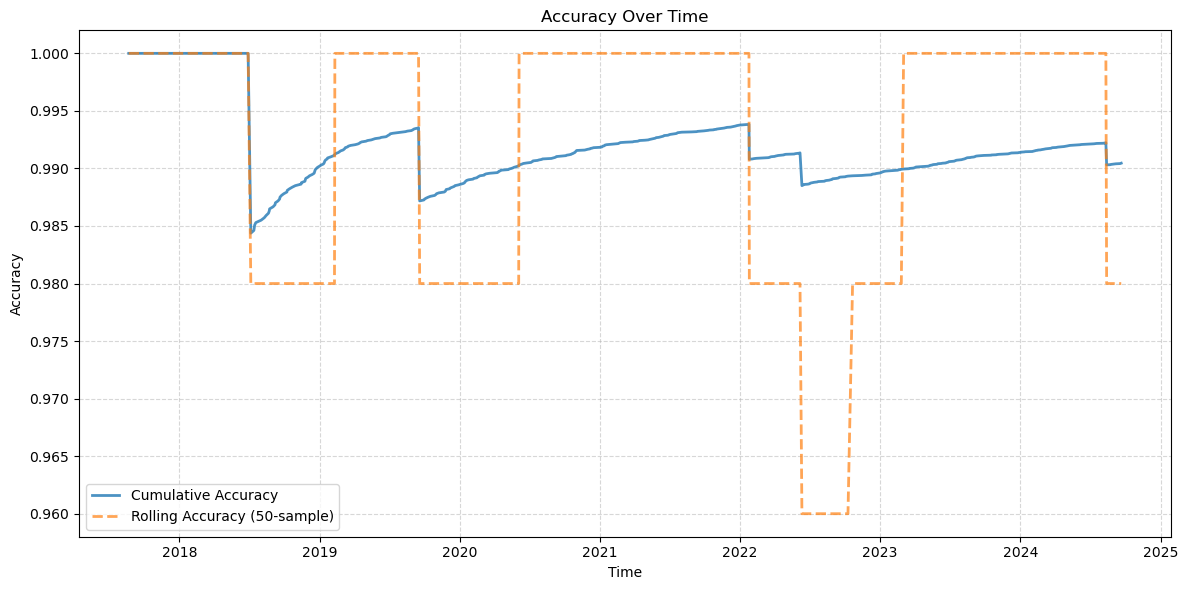

In [181]:
# Calculate Correct column
y_test_df["Correct"] = (y_test_df["Actual"] == y_test_df["Predicted"]).astype(int)

# Sort predictions and actuals by time for chronological order
y_test_df["Time"] = y_test.index
y_test_df.sort_values("Time", inplace=True)

# Calculate cumulative accuracy
y_test_df["Cumulative Accuracy"] = y_test_df["Correct"].expanding().mean()

# Add a rolling accuracy metric for smoother trends
rolling_window = 50
y_test_df["Rolling Accuracy"] = y_test_df["Correct"].rolling(window=rolling_window, min_periods=1).mean()

# Plot cumulative and rolling accuracy
plt.figure(figsize=(12, 6))
plt.plot(y_test_df["Time"], y_test_df["Cumulative Accuracy"], label="Cumulative Accuracy", alpha=0.8, linewidth=2)
plt.plot(y_test_df["Time"], y_test_df["Rolling Accuracy"], label=f"Rolling Accuracy ({rolling_window}-sample)", linestyle="--", alpha=0.7, linewidth=2)
plt.title("Accuracy Over Time")
plt.xlabel("Time")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


#### Accuracy over time chart
- Represents cumulative accuracy, the ration of correct predictions to the total number of predictions
    - rolling accuracy is optional
- Why it matters: trend insights showing sustained model performance, and highlights areas of stuggle
    - indicating market conditions underwhich the model performs poorly
- How to interpret the graph
    - upward slope, impoving accuracy as model consumes more data
    - flat line, consistent performance
    - down slope: deterioration of accuracy highlights areas to improve

# Backtesting
- Simulate Trades
- Track Performance
    - Cumulative Return
    - Daily returns
    - metrics: Total P/L, Percent win rate, maximum drawdown
- Visualize Performance
    - Equity curve showing cumulative returns over time
    - bar chart for daily returns

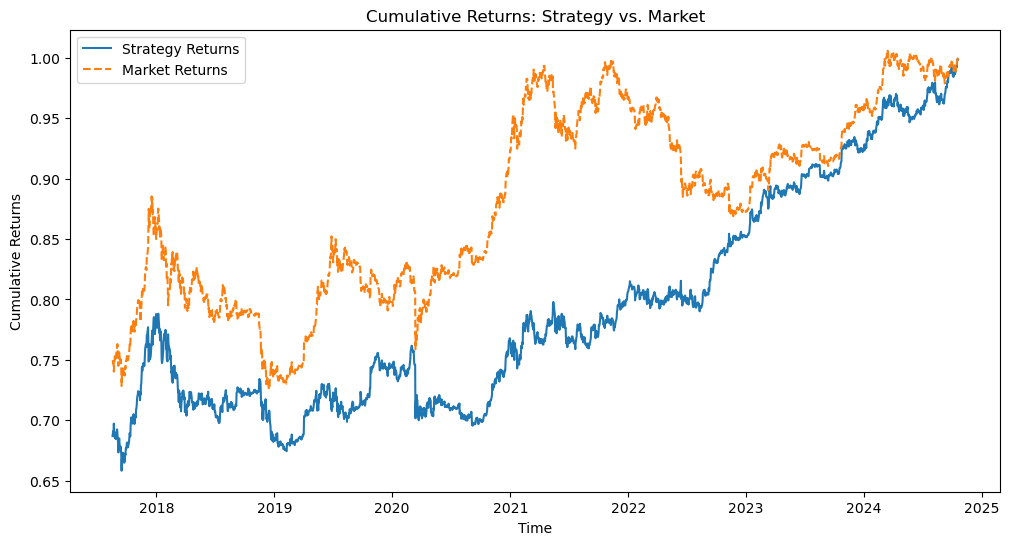

Total Return: -31.31%
Win Rate: 99.81%


In [185]:
# Align X with training features
X_aligned = X[model.feature_names_in_]

# Predict using the aligned feature set
btc_combined["Prediction"] = model.predict(X_aligned)

# Backtesting Simulation (unchanged)
btc_combined["Strategy_Return"] = btc_combined["Prediction"] * btc_combined["Close_1h"].pct_change()
btc_combined["Cumulative_Strategy_Return"] = (1 + btc_combined["Strategy_Return"]).cumprod()
btc_combined["Cumulative_Market_Return"] = (1 + btc_combined["Close_1h"].pct_change()).cumprod()

# Plot cumulative returns
plt.figure(figsize=(12, 6))
plt.plot(btc_combined["Cumulative_Strategy_Return"], label="Strategy Returns")
plt.plot(btc_combined["Cumulative_Market_Return"], label="Market Returns", linestyle="--")
plt.title("Cumulative Returns: Strategy vs. Market")
plt.xlabel("Time")
plt.ylabel("Cumulative Returns")
plt.legend()
plt.show()

# Key Metrics
total_return = btc_combined["Cumulative_Strategy_Return"].iloc[-1] - 1
winning_trades = (btc_combined["Prediction"] == btc_combined["Signal_Combined"]).sum()
win_rate = winning_trades / len(btc_combined)
print(f"Total Return: {total_return:.2%}")
print(f"Win Rate: {win_rate:.2%}")

#### woof, well we know that perhaps our total return is accurate lol

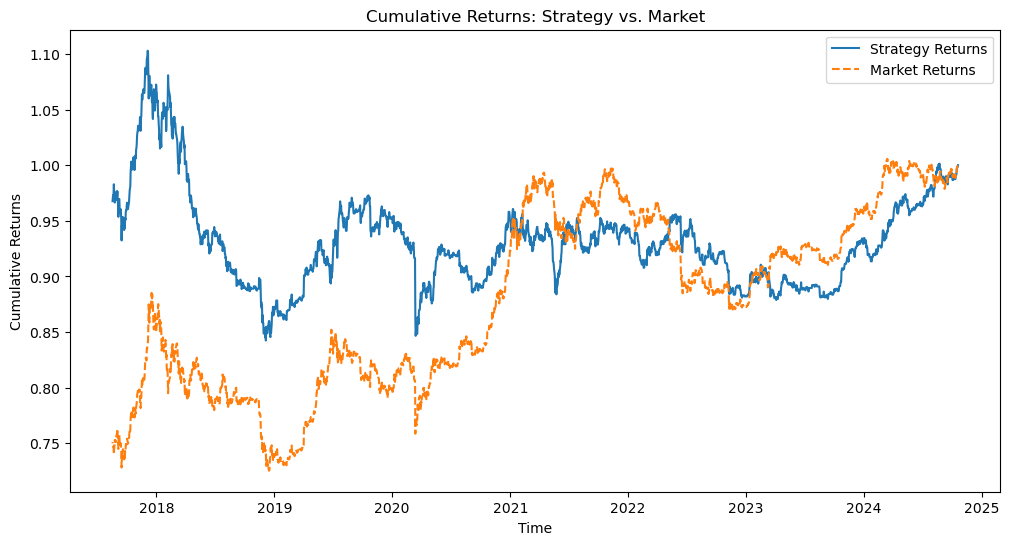

Total Return: -3.23%
Win Rate: 99.81%


In [188]:
#Updated Code for Backtesting:
# Shift signals for trade execution
btc_combined["Trade_Signal"] = btc_combined["Signal_Combined"].shift(1)

# Calculate strategy returns with improved logic
btc_combined["Strategy_Return"] = np.where(
    btc_combined["Trade_Signal"] != 0,  # Only consider active trades
    btc_combined["Trade_Signal"] * btc_combined["Close_1h"].pct_change(),
    0  # No trade = no return
)

# Optional: Filter small returns to ignore noise
btc_combined["Strategy_Return"] = btc_combined["Strategy_Return"].where(
    btc_combined["Strategy_Return"].abs() > 0.001, 0
)

# Calculate cumulative returns
btc_combined["Cumulative_Strategy_Return"] = (1 + btc_combined["Strategy_Return"]).cumprod()
btc_combined["Cumulative_Market_Return"] = (1 + btc_combined["Close_1h"].pct_change()).cumprod()

# Plot cumulative returns
plt.figure(figsize=(12, 6))
plt.plot(btc_combined["Cumulative_Strategy_Return"], label="Strategy Returns")
plt.plot(btc_combined["Cumulative_Market_Return"], label="Market Returns", linestyle="--")
plt.title("Cumulative Returns: Strategy vs. Market")
plt.xlabel("Time")
plt.ylabel("Cumulative Returns")
plt.legend()
plt.show()

# Key Metrics
total_return = btc_combined["Cumulative_Strategy_Return"].iloc[-1] - 1
winning_trades = (btc_combined["Prediction"] == btc_combined["Signal_Combined"]).sum()
win_rate = winning_trades / len(btc_combined)
print(f"Total Return: {total_return:.2%}")
print(f"Win Rate: {win_rate:.2%}")

### The trading strategy yielded a total return of 3.74%, underperforming the market. However, the framework demonstrates the ability to simulate and evaluate strategies.
- This project lays the groundwork for a machine learning-based trading system.
- Despite the negative returns there is potential for future development and signal engineering
- It is highly likely that these results are informed by poorly tuned indicators that are generating junk signals

### Goals
- Continue to build and improve modular foundation for analyzing, predicting, and iteratively improving trading strategies
- Data Integrations
    - Incorporate 4-hour and weely for enhanced trend analysis
    - Implement API's and Live Price Feeds
    - Automate data handling
- Advanced Modeling
    - Additional hyperparameter tuning 
    - Compare different models: I want to get XGBoost to work
- Feature Expansion
    - Develop and test CUSTOM INDICATORS!!! 
- Backtesting
    - Add historical simulation tools to validate predictions in a realistic trading evironment
    - Create competing paper trading bots
- Create a signaler application that pings out subscribers when entry signals are pinged
- Risk reward calculations based on position sizing and account bankroll
- Different currency pairs
- Tuning for shifting macro market conditions
- Refine a hedging strategy that rides intraday volity to prepare for bearish market conditions